In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn

### 图
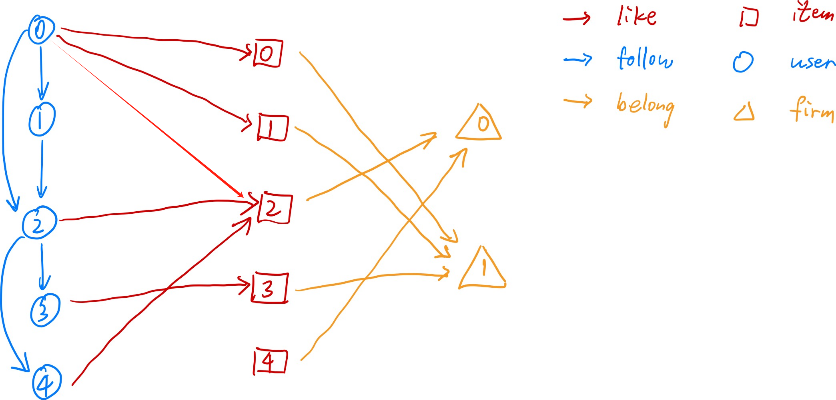

In [13]:
user_feat = torch.FloatTensor([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
item_feat = torch.FloatTensor([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
firm_feat = torch.FloatTensor([[0, 0, 0], [1, 1, 1]])

follow_feat = torch.ones(5)  # [,1]
like_feat = torch.arange(6)  # [,1]
belong_feat = torch.eye(5)  # [,5]

follow_edge = [
    [0, 0, 1, 2, 2],
    [1, 2, 2, 3, 4],
]
like_edge = [
    [0, 0, 0, 2, 3, 4],
    [0, 1, 2, 2, 3, 2],
]
belong_edge = [
    [0, 1, 2, 3, 4],
    [1, 1, 0, 1, 0],
]

firm_label = torch.LongTensor([0, 1])
item_label = torch.LongTensor([1, 1, 0, 1, 0])
user_label = torch.LongTensor([3, 0, 1, 1, 1])

In [14]:
hg = dgl.heterograph(
    {
        ("item", "belong", "firm"): (belong_edge[0], belong_edge[1]),
        ("user", "like", "item"): (like_edge[0], like_edge[1]),
        ("user", "follow", "user"): (follow_edge[0], follow_edge[1]),
    }
)


hg.nodes["user"].data["feat"] = user_feat
hg.nodes["item"].data["feat"] = item_feat
hg.nodes["firm"].data["feat"] = firm_feat
hg.nodes["user"].data["label"] = user_label
hg.nodes["item"].data["label"] = item_label
hg.nodes["firm"].data["label"] = firm_label

hg.edges["follow"].data["feat"] = follow_feat
hg.edges["like"].data["feat"] = like_feat
hg.edges["belong"].data["feat"] = belong_feat

# add self loop需要指定边，可以选择fill_data方法，sum mean ...
hg = hg.add_self_loop(etype=("user", "follow", "user"), fill_data="sum")

mods针对不同边类型定义模型
```python
 mods : dict[str, nn.Module]
        Modules associated with every edge types. The forward function of each
        module must have a `DGLGraph` object as the first argument, and
        its second argument is either a tensor object representing the node
        features or a pair of tensor object representing the source and destination
        node features.
```

### 使用现成的层

In [117]:
# weight=False就是简单相加
mods = {
    ("user", "follow", "user"): dgl.nn.GraphConv(
        3, 1, norm="none", bias=False, weight=True, allow_zero_in_degree=True
    ),
    ("user", "like", "item"): dgl.nn.GraphConv(
        3, 2, norm="none", bias=False, weight=True, allow_zero_in_degree=True
    ),
    ("item", "belong", "firm"): dgl.nn.GraphConv(
        3, 3, norm="none", bias=False, weight=True, allow_zero_in_degree=True
    ),
}

In [118]:
outputs = {nty: [] for nty in hg.dsttypes}

with torch.no_grad():
    for relation in hg.canonical_etypes:
        srctype, etype, dsttype = relation
        rel_mod = mods[relation]
        print("in", relation)

        out = rel_mod(hg[relation], hg.nodes[srctype].data["feat"])
        print(out)
        outputs[dsttype] = out

in ('item', 'belong', 'firm')
tensor([[-10.7513,   3.6640, -13.9509],
        [ -7.1675,   2.4426,  -9.3006]])
in ('user', 'follow', 'user')
tensor([[ 0.0000],
        [-1.0216],
        [-3.0649],
        [-5.1082],
        [-6.1298]])
in ('user', 'like', 'item')
tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [5.8232, 3.7955],
        [2.9116, 1.8977],
        [0.0000, 0.0000]])


### 自定义层、fn

In [7]:
etypes = ["belong", "follow", "like"]

In [8]:
in_feats = 3
out_feats = 4

In [9]:
# 定义每个关系类型的权重
weight = nn.ModuleDict(
    {name: nn.Linear(in_feats, out_feats, bias=False) for name in etypes}
)

nn.init.ones_(weight.belong.weight)
nn.init.ones_(weight.like.weight)
nn.init.ones_(weight.follow.weight)

print(weight)

ModuleDict(
  (belong): Linear(in_features=3, out_features=4, bias=False)
  (follow): Linear(in_features=3, out_features=4, bias=False)
  (like): Linear(in_features=3, out_features=4, bias=False)
)


In [42]:
funcs = {}
for c_etype in hg.canonical_etypes:
    srctype, etype, dsttype = c_etype
    Wh = weight[etype](hg.nodes[srctype].data["feat"])
    # 把它存在图中用来做消息传递
    # hg.nodes[srctype].data['Wh_%s' % etype] = Wh
    hg.srcnodes[srctype].data["Wh_%s" % etype] = Wh
    funcs[etype] = (fn.copy_u("Wh_%s" % etype, "m"), fn.sum("m", "h"))
    
hg.multi_update_all(funcs,'sum')
# sum是整合方式，这个整合方式可以是 sum、 min、 max、 mean 和 stack 中的一个

In [45]:
hg.ndata['Wh_belong']

{'item': tensor([[ 0.,  0.,  0.,  0.],
         [ 3.,  3.,  3.,  3.],
         [ 6.,  6.,  6.,  6.],
         [ 9.,  9.,  9.,  9.],
         [12., 12., 12., 12.]], grad_fn=<MmBackward0>)}

In [46]:
hg.ndata['h']

{'firm': tensor([[18., 18., 18., 18.],
         [12., 12., 12., 12.]], grad_fn=<GSpMMBackward>),
 'item': tensor([[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [18., 18., 18., 18.],
         [ 9.,  9.,  9.,  9.],
         [ 0.,  0.,  0.,  0.]], grad_fn=<GSpMMBackward>),
 'user': tensor([[ 0.,  0.,  0.,  0.],
         [ 3.,  3.,  3.,  3.],
         [ 9.,  9.,  9.,  9.],
         [15., 15., 15., 15.],
         [18., 18., 18., 18.]], grad_fn=<GSpMMBackward>)}

### 自定义message、reduce

In [47]:
def myMessage(edges:dgl.udf.EdgeBatch):
    srctype, etype, dsttype =edges.canonical_etype
    if etype == 'belong' or etype=='like':
        return {'m':edges.src['Wh_%s'%etype]}
    if etype=='follow':
        src=edges.src['Wh_%s'%etype]
        dst=edges.dst['Wh_%s'%etype]
        # h=src+dst
        return {'m':src+dst}

def 

funcs = {}
for c_etype in hg.canonical_etypes:
    srctype, etype, dsttype = c_etype
    Wh = weight[etype](hg.nodes[srctype].data["feat"])
    # 把它存在图中用来做消息传递
    # hg.nodes[srctype].data["Wh_%s" % etype] = Wh
    hg.srcnodes[srctype].data["Wh_%s" % etype] = Wh
    
    # funcs[etype] = (fn.copy_u("Wh_%s" % etype, "m"), fn.sum("m", "h"))
    funcs[etype] = (myMessage, fn.sum("m", "h"))

hg.multi_update_all(funcs,'sum')


In [48]:
hg.ndata['h']

{'firm': tensor([[18., 18., 18., 18.],
         [12., 12., 12., 12.]], grad_fn=<GSpMMBackward>),
 'item': tensor([[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [18., 18., 18., 18.],
         [ 9.,  9.,  9.,  9.],
         [ 0.,  0.,  0.,  0.]], grad_fn=<GSpMMBackward>),
 'user': tensor([[ 0.,  0.,  0.,  0.],
         [ 9.,  9.,  9.,  9.],
         [27., 27., 27., 27.],
         [33., 33., 33., 33.],
         [42., 42., 42., 42.]], grad_fn=<GSpMMBackward>)}